# NFL Competition

# Feature Engineering e Modelo de Machine Learning

- Version: 1.0: usando padrao do fork: https://www.kaggle.com/bestpredict/location-eda-8eb410
        *    Resultado: 0.012744
        *    LB: 0.01363
   
- Version: 2.0: adicionado Feature Selection com LOFO Importance
        *    Resultado: 0.012780
        *    LB: 0.01365

- Version: 3.0: adicionado novas features (apenas feature fxx + old_data + YardLine_std)
        *    Resultado: 0.012614
        *    LB: 0.01361
        
- Version: 4.0: adicionado novas features (turf)
        *    Resultado: 0.012624
        *    LB: 0.01361
        
- Version: 5.0: adicionado novas features (game_time)
        *    Resultado: 0.012635
        *    LB: 0.01362
        
- Version: 6.0: adicionado novas features (feat1, feat2, feat3, feat4) e removido (Turf + game_time)
        *    Resultado: 0.012536
        *    LB: Não é permitido
        
- Version: 7.0: alteração do modelo de bagging
        *    Resultado: 0.012474
        *    LB: 0.01362

- Version: 8.0: adicionado novas features (accY, est_prev_yards)
        *    Resultado: 0.012616
        *    LB: 0.01362
        
- Version: 9.0: adicionado novas features (norm_quat,mod_quat,norm_X,norm_Y,norm_A,norm_S)
    
        *    Resultado: 0.012604
        *    LB: 0.01361

- Version: 12.0: realizando stacking dos modelos NN e RF
    
        *    Resultado: 0.012616
        *    LB: 0.01361
        
- Version: 13.0: inclusao de otimização no modelo de NN
    
        *    Resultado: 0.012587
        *    LB: 0.01361
        
- Version: 14.0: usando todos os dados do dataset para treino
    
        *    Resultado: 0.009x
        *    LB: 0.01379
        
- Version: 15.0: adicionando novas features (seconds_need_to_first_down, seconds_need_to_YardsLine, DefendersInTheBox_vs_Distance) e alguns ajustes no modelo
    
        *    Resultado: 
        *    LB: 
        
- Version: 16.0: removido as linhas com menor quantidade de frequencia de Yards (<=50)
    
        *    Resultado: 
        *    LB: 

## 1. Importa os pacotes e o dataset de treino

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import re
import codecs
import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam, Nadam, RMSprop
from keras import optimizers

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn import model_selection

Using TensorFlow backend.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
if TRAIN_OFFLINE:
    train  = pd.read_csv('../data/train.csv', dtype={'WindSpeed': 'object'})
else:
    train  = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

In [5]:
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

## 2. Feature Engineering

In [6]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def strtofloat(x):
    try:
        return float(x)
    except:
        return -1
    
def get_time(x):
    x = x.split(":")
    return int(x[0])*60 + int(x[1])

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"    
    
def uid_aggregation(comb, main_columns, uids, aggregations):
    X = pd.DataFrame()
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = comb[[col, main_column]]
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                X[new_col_name] = comb[col].map(temp_df)
                del temp_df
                gc.collect()
    return X

def transform_time_quarter(str1):
    return int(str1[:2])*60 + int(str1[3:5])

def transform_time_all(str1,quarter):
    if quarter<=4:
        return 15*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
    if quarter ==5:
        return 10*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60

In [7]:
def create_features_01(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2
        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def velocity(x2, x1, sec) :
        return (x2 - x1) / sec
    
    def diff_x(b, c, theta) :
        if 90.0 < theta < 270.0 :
            return np.sqrt(((b ** 2) + (c ** 2)) - 2 * b * c * np.cos(theta))
        else :
            return 0
        
    def diff_y(b, c, theta) :
        if theta <= 90.0 and theta >= 270.0 :
            return - np.sqrt(((b ** 2) + (c ** 2)) - 2 * b * c * np.cos(theta))
        else :
            return 0
        
    def stop_period(speed, acc) :
        return speed / acc   

    def new_roll_velocity(x1, y1, x2, y2) :  
        x_diff = np.sqrt((x1 - x2) ** 2)
        y_diff = np.sqrt((y1 - y2) ** 2)
        return np.sqrt(x_diff + y_diff) 
    
    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]
        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')
        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X','Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]
        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    
    def rusher_features(df):
        
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Dir', 'S', 'A', 'X', 'Y']]
        rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS', 'RusherA', 'RusherX', 'RusherY']
       
        radian_angle = (90 - rusher['RusherDir']) * np.pi / 180.0
        v_horizontal = np.abs(rusher['RusherS'] * np.cos(radian_angle))
        v_vertical = np.abs(rusher['RusherS'] * np.sin(radian_angle)) 
       
        rusher['v_horizontal'] = v_horizontal
        rusher['v_vertical'] = v_vertical
        
        rusher.columns = ['GameId','PlayId', 'RusherDir', 'RusherS','RusherA','RusherX', 'RusherY','v_horizontal', 'v_vertical']
        
        return rusher
    
    def static_features(df):
        
        
        add_new_feas = []

        ## Height
        df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        
        add_new_feas.append('PlayerHeight_dense')

        ## Time
        df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

        df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
        df['PlayerBirthDate'] =df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

        ## Age
        seconds_in_year = 60*60*24*365.25
        df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        add_new_feas.append('PlayerAge')

        ## WindSpeed
        df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
        df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
        add_new_feas.append('WindSpeed_dense')

        ## Weather
        df['GameWeather_process'] = df['GameWeather'].str.lower()
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
        df['GameWeather_dense'] = df['GameWeather_process'].apply(map_weather)
        add_new_feas.append('GameWeather_dense')

        ## Orientation and Dir
        df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
        df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

        df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        add_new_feas.append("Dir_sin")
        add_new_feas.append("Dir_cos")

        ## diff Score
        df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
        add_new_feas.append("diffScoreBeforePlay")
    
        static_features = df[df['NflId'] == df['NflIdRusher']][add_new_feas+['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                                             'YardLine','Quarter','Down','Distance','DefendersInTheBox',
                                                                             'NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr','Turf',
                                                                             'VisitorTeamAbbr','PlayDirection','GameClock','Season','Team',
                                                                             'FieldPosition']].drop_duplicates()

        return static_features

    def combine_features(relative_to_back, defense, rushing, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,rushing,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df

    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    rush_feats = rusher_features(df)
    static_feats = static_features(df)
    basetable = combine_features(rel_back, def_feats, rush_feats, static_feats, deploy=deploy)
    
    return basetable

In [8]:
def create_features_02(t_):
    
    t_['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(t_.X.values) - np.square(t_.Y.values))))
    t_['fe5'] = np.square(t_['S'].values) + 2 * t_['A'].values * t_['Dis'].values  # N
    t_['fe7'] = np.arccos(np.clip(t_['X'].values / t_['Y'].values, -1, 1))  # N
    t_['fe8'] = t_['S'].values / np.clip(t_['fe1'].values, 0.6, None)
    radian_angle = (90 - t_['Dir']) * np.pi / 180.0
    t_['fe10'] = np.abs(t_['S'] * np.cos(radian_angle))
    t_['fe11'] = np.abs(t_['S'] * np.sin(radian_angle))

    t_['IsRusher'] = (t_['NflId'] == t_['NflIdRusher'])
    temp = t_[t_["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
    t_ = t_.merge(temp, on = "PlayId")
    t_["IsRusherTeam"] = t_["Team"] == t_["RusherTeam"]    

    t_["is_left"]            = t_["PlayDirection"] == "left"
    t_["old_data"]    = t_["Season"] == 2017
    t_['YardLine_std'] = 100 - t_['YardLine']
    
    t_['Orientation_rad'] = np.mod(t_.Orientation, 360) * np.pi/180.0
    t_.loc[t_.Season >= 2018, 'Orientation_rad'] = np.mod(t_.loc[t_.Season >= 2018, 'Orientation'] - 90, 360) * np.pi/180.0
    t_['Orientation_std'] = t_.Orientation_rad
    t_.loc[t_.is_left, 'Orientation_std'] = np.mod(np.pi + t_.loc[t_.is_left, 'Orientation_rad'], 2*np.pi)
    
    t_['norm_quat'] = (t_['X']**2 + t_['Y']**2 + t_['A']**2 + t_['S']**2)
    t_['mod_quat'] = (t_['norm_quat'])**0.5
    t_['norm_X'] = t_['X'] / t_['mod_quat']
    t_['norm_Y'] = t_['Y'] / t_['mod_quat']
    t_['norm_A'] = t_['A'] / t_['mod_quat']
    t_['norm_S'] = t_['S'] / t_['mod_quat']    

    t_['seconds_need_to_first_down'] = (t_['Distance']*0.9144)/t_['Dis']
    t_['seconds_need_to_YardsLine'] = (t_['YardLine']*0.9144)/t_['Dis']    
    t_['DefendersInTheBox_vs_Distance'] = t_['DefendersInTheBox'] / t_['Distance']    

    t_['time_quarter'] = t_.GameClock.map(lambda x:transform_time_quarter(x))
    t_['time_end'] = t_.apply(lambda x:transform_time_all(x.loc['GameClock'],x.loc['Quarter']),axis=1)
    
    t_ = t_.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'IsRusherTeam', 'IsRusher']).reset_index(drop = True)

    return t_

In [9]:
%time train_basetable = create_features_01(train, False)

CPU times: user 3min 7s, sys: 5.64 s, total: 3min 13s
Wall time: 3min 1s


In [10]:
%time train_basetable = create_features_02(train_basetable)

CPU times: user 2.35 s, sys: 294 ms, total: 2.65 s
Wall time: 1.63 s


In [11]:
# Cria uma copia do dataset para backup
X = train_basetable.copy()
X.shape

(23171, 76)

In [12]:
X['count'] = X.groupby('Yards')['Yards'].transform('count')

In [13]:
X = X[X['count'] >= 20]
X.shape

(22887, 77)

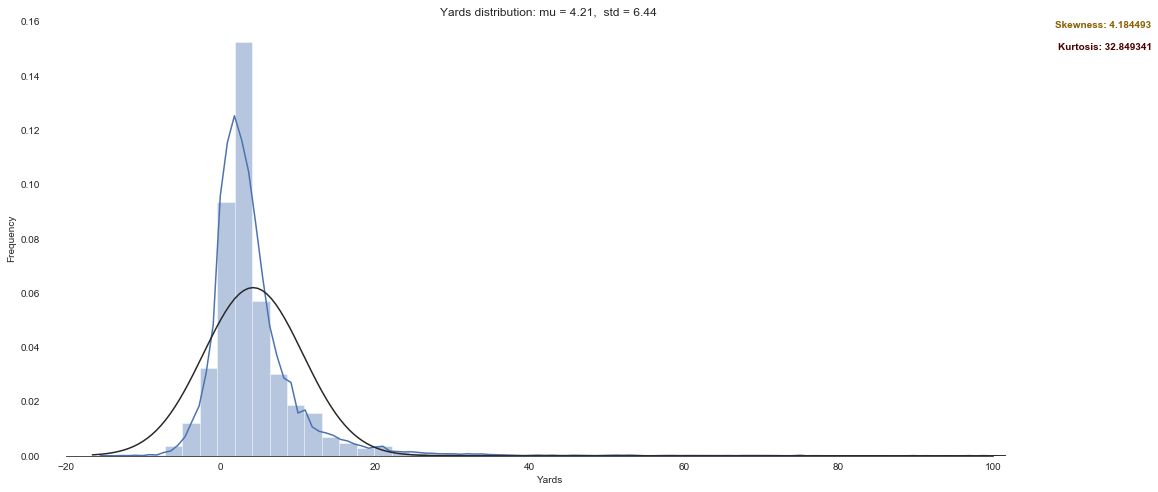

In [14]:
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm

# Analisando a variavel target 'Yards'
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(18, 8))

# Fit a normal distribution
mu, std = norm.fit(train_basetable["Yards"])

# Verificando a distribuicao de frequencia da variavel Yards
sns.distplot(train_basetable["Yards"], color="b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Yards")
ax.set(title="Yards distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

# Adicionando Skewness e Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % train_basetable["Yards"].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % train_basetable["Yards"].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

plt.show()

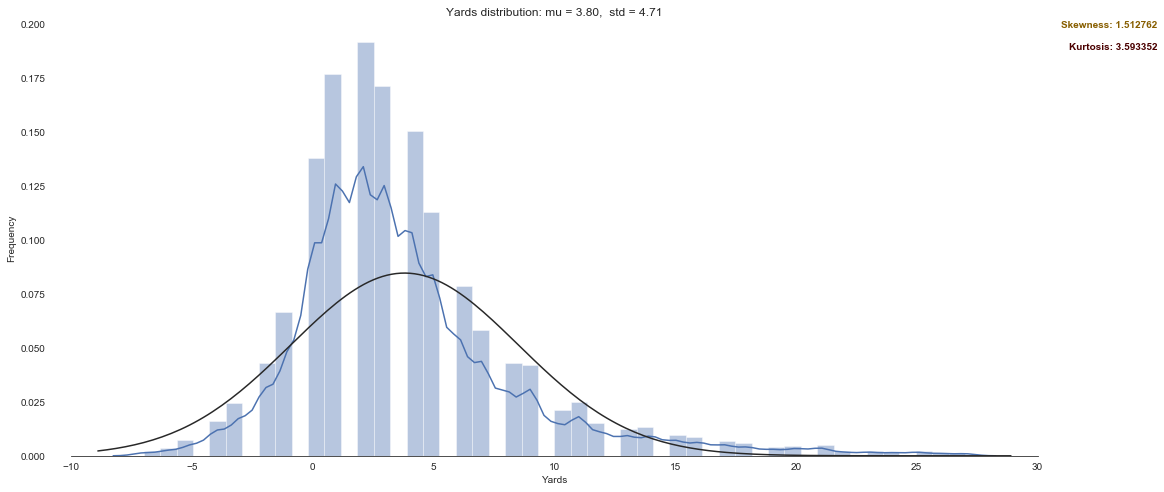

In [15]:
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm

# Analisando a variavel target 'Yards'
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(18, 8))

# Fit a normal distribution
mu, std = norm.fit(X["Yards"])

# Verificando a distribuicao de frequencia da variavel Yards
sns.distplot(X["Yards"], color="b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Yards")
ax.set(title="Yards distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

# Adicionando Skewness e Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % X["Yards"].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % X["Yards"].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

plt.show()

In [16]:
best_features = ['A','S','back_from_scrimmage','back_oriented_down_field','back_moving_down_field','old_data',
                 'def_mean_dist','def_std_dist','def_min_dist','def_max_dist','min_dist','max_dist','mean_dist',
                 'PlayerAge','PlayerHeight_dense','Dis','DefendersInTheBox',
                 'Distance','Dir','Dir_sin','Dir_cos','YardLine_std','Orientation_std',
                 'WindSpeed_dense','GameWeather_dense',
                 'fe1','fe5','fe8','fe10','fe11',
                 'norm_X','norm_Y','norm_A','norm_S',
                 'RusherDir','RusherS','RusherA','RusherX','RusherY','v_horizontal','v_vertical']

In [17]:
new_X = X.loc[:,best_features]
new_X.head()

,A,S,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,old_data,def_mean_dist,def_std_dist,def_min_dist,def_max_dist,min_dist,max_dist,mean_dist,PlayerAge,PlayerHeight_dense,Dis,DefendersInTheBox,Distance,Dir,Dir_sin,Dir_cos,YardLine_std,Orientation_std,WindSpeed_dense,GameWeather_dense,fe1,fe5,fe8,fe10,fe11,norm_X,norm_Y,norm_A,norm_S,RusherDir,RusherS,RusherA,RusherX,RusherY,v_horizontal,v_vertical
0,3.35,3.63,3.75,1,0,True,9.752491,5.327299,4.593310,22.415872,1.449724,22.415872,8.046559,25.596251,70,0.38,6.0,2,114.26,0.911690,-0.410878,55.0,0.314508,8.0,1.0,27.739531,15.7229,0.130860,3.309436,1.491487,0.800098,0.592169,0.064978,0.070409,114.26,3.63,3.35,41.25,30.53,3.309436,1.491487
1,2.41,3.06,4.07,0,0,True,10.297028,5.833217,4.287773,23.025872,0.792023,23.025872,8.614623,25.596252,70,0.34,6.0,10,47.80,0.740805,0.671721,47.0,5.747369,8.0,1.0,40.699869,11.0024,0.075185,2.266862,2.055465,0.872224,0.484153,0.042961,0.054547,47.80,3.06,2.41,48.93,27.16,2.266862,2.055465
2,2.42,5.77,3.66,1,0,True,9.903689,5.073290,4.221670,20.726285,1.646390,20.726285,8.482583,25.596253,70,0.60,7.0,10,138.04,0.668612,-0.743612,25.0,0.683820,8.0,1.0,68.732841,36.1969,0.083948,3.857889,4.290640,0.962497,0.257826,0.032650,0.077847,138.04,5.77,2.42,71.34,19.11,3.857889,4.290640
3,3.20,4.45,3.53,0,0,True,6.309354,1.834174,4.528002,9.791231,0.918096,9.791231,5.549379,26.852933,71,0.46,9.0,2,84.56,0.995496,0.094803,-8.0,6.174626,8.0,1.0,101.345209,22.7465,0.043909,4.429957,0.421875,0.970517,0.235592,0.029728,0.041340,84.56,4.45,3.20,104.47,25.36,4.429957,0.421875
4,2.53,3.90,5.01,0,0,True,11.056456,5.900009,4.288088,21.214806,0.502892,21.214806,9.168819,22.091819,71,0.44,7.0,10,157.92,0.375901,-0.926660,65.0,0.598124,8.0,1.0,12.802566,17.4364,0.304626,1.466013,3.613974,0.736852,0.666336,0.062162,0.095823,157.92,3.90,2.53,29.99,27.12,1.466013,3.613974


## 4. Criar e avaliar alguns algoritmos de Machine Learning

### 4.1. Split Treino e Validação

In [18]:
# Criar um dataset somente com as colunas mais importantes conforme visto anteriormente
#new_X = X.loc[:,best_features]
#new_X.replace(-np.inf,0,inplace=True)
#new_X.replace(np.inf,0,inplace=True)
new_X.fillna(0,inplace=True)

target = X.Yards

y = np.zeros((target.shape[0], 199))
for idx, target in enumerate(list(target)):
    y[idx][99 + target] = 1
    
# Normalizando as variaveis do dataset de treino
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)
new_X.shape, y.shape

((22887, 41), (22887, 199))

### 4.2. Teste 3 modelos (LightGBM, RF e NN)

In [19]:
# Calculate CRPS score
def crps_score(y_prediction, y_valid, shape=X.shape[0]):
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_prediction, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * shape)
    crps = np.round(val_s, 6)
    
    return crps

In [20]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [21]:
def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    inp = Input(shape = (x_tr.shape[1],))
    
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = optimizers.adam(lr = 0.05, decay = 0.05),
                  loss='categorical_crossentropy', 
                  metrics=[])
     
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=15)

    mc = ModelCheckpoint('best_model.h5',monitor='CRPS_score_val',mode='min',save_best_only=True, 
                         verbose=1, save_weights_only=True)
    
    bsz = 1024
    steps = x_tr.shape[0]/bsz
    
    model.fit(x_tr, y_tr,
              callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], 
              epochs=200, 
              #steps_per_epoch = steps,
              batch_size=bsz,
              verbose=1)
    
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = crps_score(y_pred, y_valid, shape=shape)

    return model,crps

In [22]:
%%time

loop = 2
fold = 10

oof_nn  = np.zeros([loop, y.shape[0], y.shape[1]])

models_nn = []
crps_csv_nn = []

for k in range(loop):
    kfold = KFold(fold, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
        print("-----------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("-----------")
        
        tr_x, tr_y = new_X[tr_inds], y[tr_inds]
        val_x, val_y = new_X[val_inds], y[val_inds]
        
        # Train NN
        nn, crps_nn = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        print("the %d fold crps (NN) is %f"%((k_fold+1), crps_nn))
        crps_csv_nn.append(crps_nn)
        
        #Predict OOF
        oof_nn[k, val_inds, :] = nn.predict(val_x)

-----------
Loop 1/2 Fold 1/10
-----------
validation shape 2
Epoch 1/200
20598/20598 [==============================] - 2s 109us/step - loss: 3.5621

Epoch 00001: CRPS_score_val improved from inf to 0.07357, saving model to best_model.h5
Epoch 2/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.7892

Epoch 00002: CRPS_score_val improved from 0.07357 to 0.01785, saving model to best_model.h5
Epoch 3/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.7294

Epoch 00003: CRPS_score_val improved from 0.01785 to 0.01293, saving model to best_model.h5
Epoch 4/200
20598/20598 [==============================] - 1s 65us/step - loss: 2.6923

Epoch 00004: CRPS_score_val improved from 0.01293 to 0.01181, saving model to best_model.h5
Epoch 5/200
20598/20598 [==============================] - 1s 68us/step - loss: 2.6853

Epoch 00005: CRPS_score_val improved from 0.01181 to 0.01152, saving model to best_model.h5
Epoch 6/200
20598/20598 [================

20598/20598 [==============================] - 1s 67us/step - loss: 2.5931

Epoch 00050: CRPS_score_val improved from 0.01102 to 0.01102, saving model to best_model.h5
Epoch 51/200
20598/20598 [==============================] - 1s 66us/step - loss: 2.5957

Epoch 00051: CRPS_score_val improved from 0.01102 to 0.01101, saving model to best_model.h5
Epoch 52/200
20598/20598 [==============================] - 1s 68us/step - loss: 2.5911

Epoch 00052: CRPS_score_val did not improve from 0.01101
Epoch 53/200
20598/20598 [==============================] - 1s 72us/step - loss: 2.5920

Epoch 00053: CRPS_score_val did not improve from 0.01101
Epoch 54/200
20598/20598 [==============================] - 2s 95us/step - loss: 2.5911

Epoch 00054: CRPS_score_val did not improve from 0.01101
Epoch 55/200
20598/20598 [==============================] - 2s 85us/step - loss: 2.5948

Epoch 00055: CRPS_score_val did not improve from 0.01101
Epoch 56/200
20598/20598 [==============================] - 2s 92us

20598/20598 [==============================] - 1s 68us/step - loss: 2.5721

Epoch 00102: CRPS_score_val improved from 0.01098 to 0.01098, saving model to best_model.h5
Epoch 103/200
20598/20598 [==============================] - 1s 65us/step - loss: 2.5747

Epoch 00103: CRPS_score_val did not improve from 0.01098
Epoch 104/200
20598/20598 [==============================] - 1s 65us/step - loss: 2.5716

Epoch 00104: CRPS_score_val did not improve from 0.01098
Epoch 105/200
20598/20598 [==============================] - 1s 68us/step - loss: 2.5774

Epoch 00105: CRPS_score_val did not improve from 0.01098
Epoch 106/200
20598/20598 [==============================] - 1s 63us/step - loss: 2.5721

Epoch 00106: CRPS_score_val did not improve from 0.01098
Epoch 107/200
20598/20598 [==============================] - 1s 63us/step - loss: 2.5722

Epoch 00107: CRPS_score_val improved from 0.01098 to 0.01098, saving model to best_model.h5
Epoch 108/200
20598/20598 [==============================] - 1

Epoch 15/200
20598/20598 [==============================] - 2s 76us/step - loss: 2.6358

Epoch 00015: CRPS_score_val improved from 0.01089 to 0.01088, saving model to best_model.h5
Epoch 16/200
20598/20598 [==============================] - 2s 79us/step - loss: 2.6348

Epoch 00016: CRPS_score_val improved from 0.01088 to 0.01087, saving model to best_model.h5
Epoch 17/200
20598/20598 [==============================] - 1s 72us/step - loss: 2.6336

Epoch 00017: CRPS_score_val improved from 0.01087 to 0.01087, saving model to best_model.h5
Epoch 18/200
20598/20598 [==============================] - 1s 71us/step - loss: 2.6287

Epoch 00018: CRPS_score_val improved from 0.01087 to 0.01086, saving model to best_model.h5
Epoch 19/200
20598/20598 [==============================] - 1s 66us/step - loss: 2.6234

Epoch 00019: CRPS_score_val improved from 0.01086 to 0.01084, saving model to best_model.h5
Epoch 20/200
20598/20598 [==============================] - 1s 70us/step - loss: 2.6244

Epoch 

20598/20598 [==============================] - 1s 72us/step - loss: 2.5939

Epoch 00064: CRPS_score_val did not improve from 0.01070
Epoch 65/200
20598/20598 [==============================] - 1s 71us/step - loss: 2.5895

Epoch 00065: CRPS_score_val improved from 0.01070 to 0.01069, saving model to best_model.h5
Epoch 66/200
20598/20598 [==============================] - 2s 73us/step - loss: 2.5908

Epoch 00066: CRPS_score_val did not improve from 0.01069
Epoch 67/200
20598/20598 [==============================] - 1s 69us/step - loss: 2.5916

Epoch 00067: CRPS_score_val improved from 0.01069 to 0.01069, saving model to best_model.h5
Epoch 68/200
20598/20598 [==============================] - 1s 69us/step - loss: 2.5862

Epoch 00068: CRPS_score_val improved from 0.01069 to 0.01069, saving model to best_model.h5
Epoch 69/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.5878

Epoch 00069: CRPS_score_val did not improve from 0.01069
Epoch 70/200
20598/20598 [======

Epoch 117/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.5695

Epoch 00117: CRPS_score_val did not improve from 0.01065
Epoch 118/200
20598/20598 [==============================] - 1s 66us/step - loss: 2.5751

Epoch 00118: CRPS_score_val did not improve from 0.01065
Epoch 119/200
20598/20598 [==============================] - 1s 65us/step - loss: 2.5717

Epoch 00119: CRPS_score_val did not improve from 0.01065
Epoch 120/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5734

Epoch 00120: CRPS_score_val did not improve from 0.01065
Epoch 121/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.5729

Epoch 00121: CRPS_score_val did not improve from 0.01065
Epoch 122/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.5701

Epoch 00122: CRPS_score_val improved from 0.01065 to 0.01065, saving model to best_model.h5
Epoch 123/200
20598/20598 [==============================] - 1s 67us/step - loss: 2

20598/20598 [==============================] - 1s 64us/step - loss: 2.5615

Epoch 00171: CRPS_score_val did not improve from 0.01064
Epoch 172/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5574

Epoch 00172: CRPS_score_val did not improve from 0.01064
Epoch 173/200
20598/20598 [==============================] - 1s 63us/step - loss: 2.5613

Epoch 00173: CRPS_score_val did not improve from 0.01064
Epoch 174/200
20598/20598 [==============================] - 1s 63us/step - loss: 2.5590

Epoch 00174: CRPS_score_val did not improve from 0.01064
Epoch 175/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5568

Epoch 00175: CRPS_score_val did not improve from 0.01064
Epoch 176/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5591

Epoch 00176: CRPS_score_val did not improve from 0.01064
Epoch 177/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5612

Epoch 00177: CRPS_score_val did not improv

20598/20598 [==============================] - 2s 74us/step - loss: 2.6013

Epoch 00039: CRPS_score_val improved from 0.01069 to 0.01069, saving model to best_model.h5
Epoch 40/200
20598/20598 [==============================] - 2s 74us/step - loss: 2.6045

Epoch 00040: CRPS_score_val improved from 0.01069 to 0.01068, saving model to best_model.h5
Epoch 41/200
20598/20598 [==============================] - 2s 77us/step - loss: 2.5992

Epoch 00041: CRPS_score_val improved from 0.01068 to 0.01068, saving model to best_model.h5
Epoch 42/200
20598/20598 [==============================] - 2s 80us/step - loss: 2.6020

Epoch 00042: CRPS_score_val improved from 0.01068 to 0.01068, saving model to best_model.h5
Epoch 43/200
20598/20598 [==============================] - 2s 75us/step - loss: 2.6037

Epoch 00043: CRPS_score_val improved from 0.01068 to 0.01068, saving model to best_model.h5
Epoch 44/200
20598/20598 [==============================] - 2s 77us/step - loss: 2.6026

Epoch 00044: CRPS_s

20598/20598 [==============================] - 2s 76us/step - loss: 2.5772

Epoch 00092: CRPS_score_val did not improve from 0.01063
Epoch 93/200
20598/20598 [==============================] - 2s 75us/step - loss: 2.5747

Epoch 00093: CRPS_score_val did not improve from 0.01063
Epoch 94/200
20598/20598 [==============================] - 2s 80us/step - loss: 2.5778

Epoch 00094: CRPS_score_val did not improve from 0.01063
Epoch 95/200
20598/20598 [==============================] - 2s 82us/step - loss: 2.5759
Restoring model weights from the end of the best epoch

Epoch 00095: CRPS_score_val did not improve from 0.01063
Epoch 00095: early stopping
the 3 fold crps (NN) is 0.010631
-----------
Loop 1/2 Fold 4/10
-----------
validation shape 2
Epoch 1/200
20598/20598 [==============================] - 2s 116us/step - loss: 3.5901

Epoch 00001: CRPS_score_val improved from inf to 0.02367, saving model to best_model.h5
Epoch 2/200
20598/20598 [==============================] - 1s 70us/step - 

20598/20598 [==============================] - 1s 72us/step - loss: 2.5982

Epoch 00044: CRPS_score_val did not improve from 0.01080
Epoch 45/200
20598/20598 [==============================] - 2s 79us/step - loss: 2.5983

Epoch 00045: CRPS_score_val did not improve from 0.01080
Epoch 46/200
20598/20598 [==============================] - 2s 75us/step - loss: 2.5986

Epoch 00046: CRPS_score_val improved from 0.01080 to 0.01080, saving model to best_model.h5
Epoch 47/200
20598/20598 [==============================] - 2s 77us/step - loss: 2.5949

Epoch 00047: CRPS_score_val improved from 0.01080 to 0.01079, saving model to best_model.h5
Epoch 48/200
20598/20598 [==============================] - 2s 84us/step - loss: 2.5937

Epoch 00048: CRPS_score_val did not improve from 0.01079
Epoch 49/200
20598/20598 [==============================] - 2s 74us/step - loss: 2.5944

Epoch 00049: CRPS_score_val did not improve from 0.01079
Epoch 50/200
20598/20598 [==============================] - 2s 79us

20598/20598 [==============================] - 1s 70us/step - loss: 2.8241

Epoch 00002: CRPS_score_val improved from 0.03537 to 0.01759, saving model to best_model.h5
Epoch 3/200
20598/20598 [==============================] - 1s 69us/step - loss: 2.7281

Epoch 00003: CRPS_score_val improved from 0.01759 to 0.01282, saving model to best_model.h5
Epoch 4/200
20598/20598 [==============================] - 1s 70us/step - loss: 2.7009

Epoch 00004: CRPS_score_val improved from 0.01282 to 0.01166, saving model to best_model.h5
Epoch 5/200
20598/20598 [==============================] - 1s 73us/step - loss: 2.6866

Epoch 00005: CRPS_score_val improved from 0.01166 to 0.01117, saving model to best_model.h5
Epoch 6/200
20598/20598 [==============================] - 2s 75us/step - loss: 2.6794

Epoch 00006: CRPS_score_val improved from 0.01117 to 0.01101, saving model to best_model.h5
Epoch 7/200
20598/20598 [==============================] - 2s 77us/step - loss: 2.6682

Epoch 00007: CRPS_score_

20598/20598 [==============================] - 2s 75us/step - loss: 2.5933

Epoch 00051: CRPS_score_val did not improve from 0.01064
Epoch 52/200
20598/20598 [==============================] - 2s 74us/step - loss: 2.5903

Epoch 00052: CRPS_score_val improved from 0.01064 to 0.01064, saving model to best_model.h5
Epoch 53/200
20598/20598 [==============================] - 2s 74us/step - loss: 2.5905

Epoch 00053: CRPS_score_val improved from 0.01064 to 0.01064, saving model to best_model.h5
Epoch 54/200
20598/20598 [==============================] - 2s 76us/step - loss: 2.5913

Epoch 00054: CRPS_score_val did not improve from 0.01064
Epoch 55/200
20598/20598 [==============================] - 2s 76us/step - loss: 2.5894

Epoch 00055: CRPS_score_val improved from 0.01064 to 0.01064, saving model to best_model.h5
Epoch 56/200
20598/20598 [==============================] - 2s 78us/step - loss: 2.5922

Epoch 00056: CRPS_score_val did not improve from 0.01064
Epoch 57/200
20598/20598 [======


Epoch 00103: CRPS_score_val did not improve from 0.01060
Epoch 104/200
20598/20598 [==============================] - 1s 69us/step - loss: 2.5760

Epoch 00104: CRPS_score_val improved from 0.01060 to 0.01060, saving model to best_model.h5
Epoch 105/200
20598/20598 [==============================] - 1s 63us/step - loss: 2.5726

Epoch 00105: CRPS_score_val did not improve from 0.01060
Epoch 106/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5700

Epoch 00106: CRPS_score_val did not improve from 0.01060
Epoch 107/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5701

Epoch 00107: CRPS_score_val did not improve from 0.01060
Epoch 108/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5704

Epoch 00108: CRPS_score_val did not improve from 0.01060
Epoch 109/200
20598/20598 [==============================] - 1s 68us/step - loss: 2.5711

Epoch 00109: CRPS_score_val improved from 0.01060 to 0.01059, saving model to best

20598/20598 [==============================] - 1s 65us/step - loss: 2.6450

Epoch 00013: CRPS_score_val improved from 0.01086 to 0.01085, saving model to best_model.h5
Epoch 14/200
20598/20598 [==============================] - 1s 66us/step - loss: 2.6375

Epoch 00014: CRPS_score_val improved from 0.01085 to 0.01084, saving model to best_model.h5
Epoch 15/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.6372

Epoch 00015: CRPS_score_val improved from 0.01084 to 0.01083, saving model to best_model.h5
Epoch 16/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.6354

Epoch 00016: CRPS_score_val improved from 0.01083 to 0.01082, saving model to best_model.h5
Epoch 17/200
20598/20598 [==============================] - 1s 65us/step - loss: 2.6290

Epoch 00017: CRPS_score_val improved from 0.01082 to 0.01082, saving model to best_model.h5
Epoch 18/200
20598/20598 [==============================] - 1s 65us/step - loss: 2.6291

Epoch 00018: CRPS_s

20598/20598 [==============================] - 1s 69us/step - loss: 2.5910

Epoch 00063: CRPS_score_val did not improve from 0.01073
Epoch 64/200
20598/20598 [==============================] - 1s 68us/step - loss: 2.5925

Epoch 00064: CRPS_score_val did not improve from 0.01073
Epoch 65/200
20598/20598 [==============================] - 1s 69us/step - loss: 2.5865

Epoch 00065: CRPS_score_val did not improve from 0.01073
Epoch 66/200
20598/20598 [==============================] - 1s 67us/step - loss: 2.5868

Epoch 00066: CRPS_score_val did not improve from 0.01073
Epoch 67/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5869

Epoch 00067: CRPS_score_val did not improve from 0.01073
Epoch 68/200
20598/20598 [==============================] - 1s 64us/step - loss: 2.5896

Epoch 00068: CRPS_score_val did not improve from 0.01073
Epoch 69/200
20598/20598 [==============================] - 1s 70us/step - loss: 2.5874

Epoch 00069: CRPS_score_val did not improve from

20598/20598 [==============================] - 2s 77us/step - loss: 2.6049

Epoch 00039: CRPS_score_val improved from 0.01072 to 0.01071, saving model to best_model.h5
Epoch 40/200
20598/20598 [==============================] - 2s 74us/step - loss: 2.6069

Epoch 00040: CRPS_score_val improved from 0.01071 to 0.01071, saving model to best_model.h5
Epoch 41/200
20598/20598 [==============================] - 2s 79us/step - loss: 2.6059

Epoch 00041: CRPS_score_val did not improve from 0.01071
Epoch 42/200
20598/20598 [==============================] - 2s 78us/step - loss: 2.6032

Epoch 00042: CRPS_score_val improved from 0.01071 to 0.01070, saving model to best_model.h5
Epoch 43/200
20598/20598 [==============================] - 2s 76us/step - loss: 2.6006

Epoch 00043: CRPS_score_val did not improve from 0.01070
Epoch 44/200
20598/20598 [==============================] - 1s 69us/step - loss: 2.6001

Epoch 00044: CRPS_score_val improved from 0.01070 to 0.01070, saving model to best_model.

Epoch 90/200
20598/20598 [==============================] - 2s 75us/step - loss: 2.5792

Epoch 00090: CRPS_score_val improved from 0.01064 to 0.01064, saving model to best_model.h5
Epoch 91/200
20598/20598 [==============================] - 2s 74us/step - loss: 2.5820

Epoch 00091: CRPS_score_val improved from 0.01064 to 0.01064, saving model to best_model.h5
Epoch 92/200
20598/20598 [==============================] - 2s 75us/step - loss: 2.5775

Epoch 00092: CRPS_score_val improved from 0.01064 to 0.01064, saving model to best_model.h5
Epoch 93/200
20598/20598 [==============================] - 2s 77us/step - loss: 2.5758

Epoch 00093: CRPS_score_val did not improve from 0.01064
Epoch 94/200
20598/20598 [==============================] - 2s 80us/step - loss: 2.5814

Epoch 00094: CRPS_score_val did not improve from 0.01064
Epoch 95/200
20598/20598 [==============================] - 2s 78us/step - loss: 2.5803

Epoch 00095: CRPS_score_val did not improve from 0.01064
Epoch 96/200
20598/

KeyboardInterrupt: 

In [23]:
crps_oof_nn  = []

for k in range(loop):
    crps_oof_nn.append(crps_score(oof_nn[k,...], y))

In [24]:
print("mean crps (NN) is %f"%np.mean(crps_csv_nn))
print("mean OOF crps (NN) is %f"%np.mean(crps_oof_nn))

mean crps (NN) is 0.010720
mean OOF crps (NN) is 0.341606


## Blending Weight Optimisation

In [25]:
def predict(x_te, models_nn):
    model_num_nn = len(models_nn)
    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = m.predict(x_te, batch_size=1024)
        else:
            y_pred_nn += m.predict(x_te, batch_size=1024)
            
    y_pred_nn = y_pred_nn / model_num_nn
    
    return y_pred_nn

## 5. Realizar a submissão para o Kaggle

In [26]:
%%time

if  TRAIN_OFFLINE==False:
    
    from kaggle.competitions import nflrush
    env = nflrush.make_env()
    iter_test = env.iter_test()
    df_prev = pd.DataFrame()
    df_test = pd.DataFrame()

    for (test_df, sample_prediction_df) in tqdm_notebook(iter_test):
        basetable = create_features_01(test_df, deploy=True)
        basetable = create_features_02(basetable)

        # Considerar somente as colunas do Feature Selection
        basetable = basetable.loc[:,best_features]
        basetable.fillna(0,inplace=True)
    
        scaled_basetable = scaler.transform(basetable)

        y_pred = predict(scaled_basetable, models_nn)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

        preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
        
        df_test = df_test.append(basetable)
        df_prev = df_prev.append(preds_df)
    
        env.predict(preds_df)

    env.write_submission_file()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


In [27]:
df_test.head()

NameError: name 'df_test' is not defined

In [ ]:
df_prev.head()